## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

C:\Users\10709151\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
from keras.regularizers import l1, l2, l1_l2
"""
建立神經網路，並加入 L1&L2
"""
def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_ratio,l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio,l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
from keras.layers import Dropout

def build_mlp_dout(input_shape, output_units=10, num_neurons=[256, 128], drp_ratio=0.3):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING = 0.001
EPOCHS = 50
BATCH_SIZE = 256
DECAY = 0
MOMENTUM = 0.95
BATCH_SIZEs = [128, 256]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for BATCH_SIZE in BATCH_SIZEs:
    print("Experiment with optimizer: Adam")
    model1 = build_mlp(input_shape=x_train.shape[1:])
    model2 = build_mlp_l1l2(input_shape=x_train.shape[1:])
    model3 = build_mlp_dout(input_shape=x_train.shape[1:])
    
    model1.summary()
    model2.summary()
    model3.summary()
    
    optimizer = keras.optimizers.Adam(lr=LEARNING, decay=DECAY)
    
    model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model3.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model1.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)
    model2.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)
    model3.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)

    # Collect results
    train_loss = model1.history.history["loss"]
    valid_loss = model1.history.history["val_loss"]
    train_acc = model1.history.history["acc"]
    valid_acc = model1.history.history["val_acc"]

    exp_name_tag = "OPT:Adam BATCH_SIZE = 128,256"
    results[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}
    
    train_loss2 = model2.history.history["loss"]
    valid_loss2 = model2.history.history["val_loss"]
    train_acc2 = model2.history.history["acc"]
    valid_acc2 = model2.history.history["val_acc"]

    exp_name_tag = "OPT:Adam BATCH_SIZE = 128,256, L1L2"
    results[exp_name_tag] = {'train-loss': train_loss2,
                                'valid-loss': valid_loss2,
                                'train-acc': train_acc2,
                                'valid-acc': valid_acc2}
    
    train_loss3 = model3.history.history["loss"]
    valid_loss3 = model3.history.history["val_loss"]
    train_acc3 = model3.history.history["acc"]
    valid_acc3 = model3.history.history["val_acc"]

    exp_name_tag = "OPT:Adam BATCH_SIZE = 128,256< Dropout"
    results[exp_name_tag] = {'train-loss': train_loss3,
                                'valid-loss': valid_loss3,
                                'train-acc': train_acc3,
                                'valid-acc': valid_acc3}

Experiment with optimizer: Adam
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
______________________________________

50000/50000 [==============================] - 3s 59us/step - loss: 1.0789 - acc: 0.6143 - val_loss: 1.4208 - val_acc: 0.5176
Epoch 40/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.0705 - acc: 0.6207 - val_loss: 1.4225 - val_acc: 0.5179
Epoch 41/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0582 - acc: 0.6208 - val_loss: 1.4269 - val_acc: 0.5072
Epoch 42/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0657 - acc: 0.6196 - val_loss: 1.4404 - val_acc: 0.5161
Epoch 43/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.0566 - acc: 0.6217 - val_loss: 1.4567 - val_acc: 0.5100
Epoch 44/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.0451 - acc: 0.6256 - val_loss: 1.4091 - val_acc: 0.5259
Epoch 45/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.0377 - acc: 0.6311 - val_loss: 1.4142 - val_acc: 0.5206
Epoch 46/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 67us/step - loss: 1.5498 - acc: 0.4946 - val_loss: 1.5893 - val_acc: 0.4839
Epoch 49/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.5568 - acc: 0.4918 - val_loss: 1.6070 - val_acc: 0.4756
Epoch 50/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.5565 - acc: 0.4914 - val_loss: 1.6039 - val_acc: 0.4760
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 74us/step - loss: 2.1831 - acc: 0.1789 - val_loss: 1.9978 - val_acc: 0.2506
Epoch 2/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.0271 - acc: 0.2275 - val_loss: 1.9190 - val_acc: 0.3011
Epoch 3/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.9706 - acc: 0.2619 - val_loss: 1.9069 - val_acc: 0.3065
Epoch 4/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.9474 - acc: 0.2716 - val_loss: 1.8794 - val_acc: 0.3338


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.9002 - acc: 0.3182 - val_loss: 1.7706 - val_acc: 0.3646
Epoch 2/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.6984 - acc: 0.3983 - val_loss: 1.6770 - val_acc: 0.4027
Epoch 3/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.6195 - acc: 0.4248 - val_loss: 1.6224 - val_acc: 0.4265
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.5668 - acc: 0.4468 - val_loss: 1.5571 - val_acc: 0.4485
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.5247 - acc: 0.4597 - val_loss: 1.5318 - val_acc: 0.4542
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4987 - acc: 0.4708 - val_loss: 1.5321 - val_acc: 0.4546
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4571 - acc: 0.4836 - val_loss: 1.4739 - val_acc

Epoch 10/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.7413 - acc: 0.4298 - val_loss: 1.7677 - val_acc: 0.4220
Epoch 11/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.7145 - acc: 0.4382 - val_loss: 1.6980 - val_acc: 0.4449
Epoch 12/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.6950 - acc: 0.4463 - val_loss: 1.7003 - val_acc: 0.4460
Epoch 13/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.6849 - acc: 0.4477 - val_loss: 1.6635 - val_acc: 0.4568
Epoch 14/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.6707 - acc: 0.4516 - val_loss: 1.6809 - val_acc: 0.4516
Epoch 15/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.6608 - acc: 0.4556 - val_loss: 1.6710 - val_acc: 0.4564
Epoch 16/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.6552 - acc: 0.4576 - val_loss: 1.6744 - val_acc: 0.4500
Epoch 17/50
50000/50000 [=========

50000/50000 [==============================] - 2s 48us/step - loss: 1.7756 - acc: 0.3545 - val_loss: 1.7219 - val_acc: 0.3852
Epoch 20/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.7683 - acc: 0.3572 - val_loss: 1.7494 - val_acc: 0.3845
Epoch 21/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.7657 - acc: 0.3615 - val_loss: 1.7183 - val_acc: 0.3915
Epoch 22/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.7612 - acc: 0.3608 - val_loss: 1.6861 - val_acc: 0.4158
Epoch 23/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7544 - acc: 0.3650 - val_loss: 1.7030 - val_acc: 0.4113
Epoch 24/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7494 - acc: 0.3671 - val_loss: 1.7117 - val_acc: 0.4064
Epoch 25/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7518 - acc: 0.3656 - val_loss: 1.7135 - val_acc: 0.4097
Epoch 26/50
50000/50000 [=====================

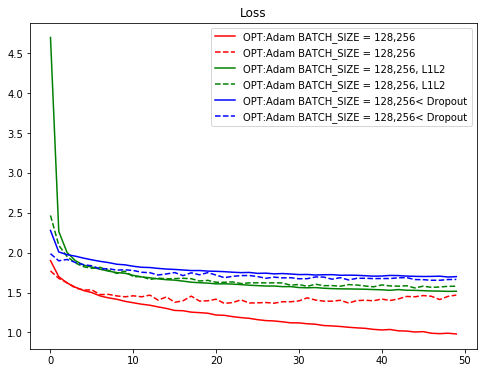

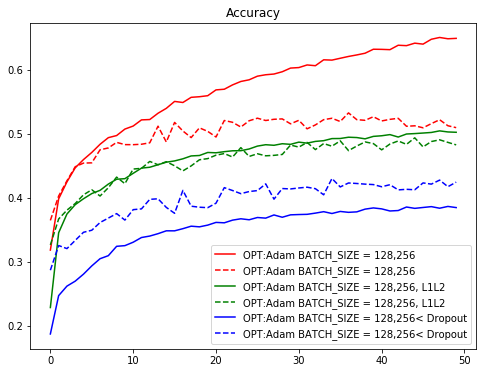

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()